List the approach names below:

In [2]:
MODELS = ['pointnet', 'pointnet++', 'so-net']

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **MODELS COUNT x TEST POINT CLOUDS CLOUD x CLASSES COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [3]:
CLASSES_COUNT = 40
MODELS_COUNT = 10

import os
import numpy as np
probabilities = {}
true_labels = {}
for model in MODELS:
    prob_filepath = os.path.join(model, 'probabilities.npy')
    probabilities[model] = np.load(prob_filepath)
    probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))
    label_filepath = os.path.join(model, 'true_labels.npy')
    true_labels[model] = np.load(label_filepath)

Now, we want to know how instance classification accuracy depends on the number of the ensemble of independently train models. We will check two ensembling methods: mean and mode operation and for each number of ensembled models there will be ten different sets taken into consideration and the median value will be shown on the figures below.

In [34]:
####################################################################################
# Constants
####################################################################################

ENSEMBLE_MODELS_NUMBER = 10

import math
import statistics
from scipy import stats

####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)

subsets = {}
for num_ens in range(1, ENSEMBLE_MODELS_NUMBER+1):
    subset = get_k_combinations_of_n_elems(len(probabilities[model]), num_ens, ENSEMBLE_MODELS_NUMBER)
    subsets[num_ens] = subset

####################################################################################
# Calc acc with mode
####################################################################################

instance_accuracy_mode = {}
for model in MODELS:
    instance_accuracy_mode[model] = {}
    for num_ens in subsets:
        num_ens_accs = []
        for subset in subsets[num_ens]:
            preds = []
            true = true_labels[model]
            for model_no in subset:
                preds.append(np.argmax(probabilities[model][model_no], axis=-1))
            preds = np.transpose(np.array(preds))
            preds = np.squeeze(stats.mode(preds, axis=-1)[0])
            accy = float(np.sum(preds == true))/len(true)
            num_ens_accs.append(accy)
        instance_accuracy_mode[model][num_ens] = statistics.median(num_ens_accs)
        
####################################################################################
# Calc acc with mean
####################################################################################

instance_accuracy_mean = {}
for model in MODELS:
    instance_accuracy_mean[model] = {}
    for num_ens in subsets:
        num_ens_accs = []
        for subset in subsets[num_ens]:
            preds = []
            true = true_labels[model]
            for model_no in subset:
                preds.append(probabilities[model][model_no])
            preds = np.transpose(np.array(preds), axes=(1,2,0))
            preds = np.argmax(np.mean(preds, axis=-1), axis=-1)
            accy = float(np.sum(preds == true))/len(true)
            num_ens_accs.append(accy)
        instance_accuracy_mean[model][num_ens] = statistics.median(num_ens_accs)

Plot instance accuracy for two aggregation methods in the function of ensambled individually trained models.

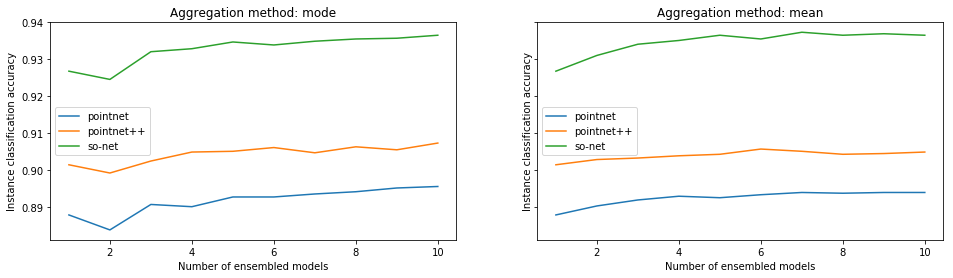

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracy(ax, instance_accuracy, aggregation_method='mode'):
    handles = []
    for model in MODELS:
        x = instance_accuracy[model].keys()
        y = [instance_accuracy[model][i] for i in x]
        handle, = ax.plot(x, y, label=model)
        handles.append(handle)
    ax.set_title('Aggregation method: ' + aggregation_method)
    ax.set_xlabel('Number of ensembled models')
    ax.set_ylabel('Instance classification accuracy')
    ax.legend(handles=handles)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
plot_accuracy(ax1, instance_accuracy_mode, 'mode')
plot_accuracy(ax2, instance_accuracy_mean, 'mean')